In [1]:
import os
from PIL import Image
import numpy as np 
import pandas as pd
from skimage.io import imread
import tensorflow as tf
import os

from collections import Counter
from matplotlib import pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

from tensorflow.keras.preprocessing import image

2023-05-30 13:25:08.022156: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-30 13:25:24.804587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64:/home/trer/.conda/envs/PIL_env/lib/
2023-05-30 13:25:24.806106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64:/home/trer/.conda/envs/PIL_env/lib/
2023-05-30 13:25:24.806153: W tensorflow/compiler/tf2tensorrt/

### Functions 

In [2]:
def display_image(img_path, figsize=(3,3)):
    img = imread(img_path)
    print(img.shape)
    plt.figure(figsize = figsize)
    plt.imshow(img, cmap='gray')
    plt.show()
    return img

In [3]:
def preprocess_img(img_path, printing=False, Indiana=False):
    
    if Indiana == True:
        im = Image.open(img_path)
        img = np.array(im).astype(int)
    
    else:
        img = imread(img_path)
    
    if printing:
        plt.imshow(img)
        plt.show()
    
    # remove the extra channels    
    if len(img.shape) == 3:
        img = img[:,:,0]

    # resize with padding:
    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, -1)
    img = tf.image.resize_with_pad(img, 512, 512)
        
    return img

In [ ]:
def get_filename_list(path):
    files = os.listdir(path)
    return files

# Montgomery dataset

In [4]:
# Reading the lists of images
# cxr_dir_path = "../../Data/Segmentation-data/Montgomery/CXR_png/"
# mask_dir_path = "../../Data/Segmentation-data/Montgomery/ManualMask/"
# reading_dir_path = "../../Data/Segmentation-data/Montgomery/ClinicalReadings"

cxr_dir_path = "../../../purrlab_students/Segmentation-data/Montgomery/CXR_png/"
mask_dir_path = "../../../purrlab_students/Segmentation-data/Montgomery/ManualMask/"
reading_dir_path = "../../../purrlab_students/Segmentation-data/Montgomery/ClinicalReadings"

In [17]:
# Obtaining the file names in lists
# (removing the last file because it's a 'Thumbs.db' file)
cxr_png = get_filename_list(cxr_dir_path)[:-1]
right_mask = get_filename_list(mask_dir_path + 'rightMask')
left_mask = get_filename_list(mask_dir_path + 'leftMask')[:-1]
clinical_reading = get_filename_list(reading_dir_path)

In [29]:
# Creating dataframe with the image lists
montgomery_df = pd.DataFrame(list(zip(cxr_png, left_mask, clinical_reading)), columns=['ImageID', "LeftMask", 'ClinicalReading'])

### Preprocessing 

In [31]:
# Preprocess the Montgomory CHX image 
for idx in range(len(montgomery_df)):
    
    path = cxr_dir_path + montgomery_df["ImageID"][idx]
    img = preprocess_img(path, printing=False)
    
    if isinstance(img, str):
        s = montgomery_df.iloc[idx]
        s_df = pd.DataFrame([s.tolist()], columns=s.index)
        s_df.to_csv("Invalid_images.csv", mode='a', header=False, sep=',')
        continue 
        
    else:
        new_path = path[:44]+ "Segmentation_preprocessed/Montgomery/Images/" + montgomery_df["ImageID"][idx]
#         tf.keras.utils.save_img(new_path, img, scale=True, data_format="channels_last")

../../../purrlab_students/Segmentation-data/Montgomery/CXR_png/MCUCXR_0084_0.png
../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Montgomery/Images/MCUCXR_0084_0.png


In [56]:
# preprocess mask and combine left and right mask 
def preprocess_mask(img_path_left, img_path_right, printing=False):
    
    img_left = imread(img_path_left)
    img_right = imread(img_path_right)
    img = np.array(img_left) + np.array(img_right)

    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, -1)
    img = tf.image.resize_with_pad(img, 512, 512)
            
    img = np.where(img!=0, 1, 0)
    
    return img


In [10]:

# Montgomory mask
for idx in range(len(montgomery_df)):
    
    path_left = mask_dir_path + 'leftMask/' + montgomery_df["ImageID"][idx]
    path_right = mask_dir_path + 'rightMask/' + montgomery_df["ImageID"][idx]
    
    img = preprocess_mask(path_left, path_right, printing=False)
    break
        
    new_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Montgomery/Masks/" + montgomery_df["ImageID"][idx]
#     tf.keras.utils.save_img(new_path, img, scale=False, data_format="channels_last")

# Shenzhen Dataset

In [64]:
# Reading the lists of images
# cxr_dir_path = "../../Data/Segmentation-data/Shenzhen/CXR_png/"
cxr_dir_path = "../../../purrlab_students/Segmentation-data/Shenzhen/CXR_png/"

# mask_dir_path = "../../Data/Segmentation-data/Shenzhen/Mask/"
mask_dir_path = "../../../purrlab_students/Segmentation-data/Shenzhen/Mask/"


# Obtaining the file names in lists
cxr_png = get_filename_list(cxr_dir_path)
mask_png = get_filename_list(mask_dir_path)
masks = [i[:-9] + i[-4:] for i in mask_png]
masks[:2]

['CHNCXR_0001_0.png', 'CHNCXR_0002_0.png']

In [65]:
# images and CXR does not corresponds
print(len(cxr_png))
print(len(masks))

663
566


In [66]:
# it is missing 97 masks 
len(set(cxr_png).symmetric_difference(set(masks)))-1 # for the 'Thumbs.db'

96

### Preprocessing 

In [76]:
# Shenzhen CHX - using mask to ensure the correct name and image 
for i in masks:
    path = cxr_dir_path + i
    img = preprocess_img(path, printing=False)
    
    new_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Shenzhen/Images/" + i
#     tf.keras.utils.save_img(new_path, img, scale=True, data_format="channels_last")

In [92]:
# Shenzhen Masks
for i in masks:
    
    path = mask_dir_path + i[:-4] + '_mask.png'

    img = preprocess_img(path, printing=False)
    img = np.where(img!=0, 1, 0)
    
    new_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Shenzhen/Masks/" + i

In [79]:
cxr_png[idx][:-4] + "_mask.png"

'CHNCXR_0001_0_mask.png'

## Indiana

In [94]:
# Reading the lists of images
# cxr_dir_path = "../../Data/Segmentation-data/Shenzhen/CXR_png/"
cxr_dir_path = "../../../purrlab_students/Segmentation-data/Indiana/CXR_png/"

# mask_dir_path = "../../Data/Segmentation-data/Shenzhen/Mask/"
mask_dir_path = "../../../purrlab_students/Segmentation-data/Indiana/GTMask/"

# Obtaining the file names in lists
cxr_png = get_filename_list(cxr_dir_path)
mask_png = get_filename_list(mask_dir_path)

print(cxr_png[0])
print(mask_png[0])
len(cxr_png) == len(mask_png)

1036_IM-0029-1001.png
1036_IM-0029-1001.tif


True

In [62]:
mask_dir_path + mask_png[55]

'../../../purrlab_students/Segmentation-data/Indiana/GTMask/Thumbs.db'

### Preprocessing 

In [11]:
# Indiana CHX
for idx in range(len(cxr_png)-1):
    
    path = cxr_dir_path + cxr_png[idx]
    img = preprocess_img(path, printing=False)

    new_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Indiana/Images/" + cxr_png[idx]
#     tf.keras.utils.save_img(new_path, img, scale=True, data_format="channels_last")


In [ ]:
# Indiana Masks
for idx in range(len(mask_png)-1):
    
    path = mask_dir_path + mask_png[idx]
    img = preprocess_img(path, printing=False, Indiana=True)
    img = np.where(img!=0, 1, 0)
    
    # using the cxr_png since it have the correct extention
    new_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Indiana/Masks/" + cxr_png[idx]


#  JSRT

In [108]:
cxr_dir_path = "../../../purrlab_students/Segmentation-data/JSRT/images/"
mask_dir_path_fold1 = "../../../purrlab_students/Segmentation-data/JSRT/fold1/masks"
mask_dir_path_fold2 = "../../../purrlab_students/Segmentation-data/JSRT/fold2/masks"

In [110]:
# Obtaining the file names in lists
# (removing the last file because it's a 'Thumbs.db' file)
cxr_png = get_filename_list(cxr_dir_path)
# right_mask = get_filename_list(mask_dir_path + 'rightMask')
# left_mask = get_filename_list(mask_dir_path + 'leftMask')[:-1]
# clinical_reading = get_filename_list(reading_dir_path)
cxr_png[:1]
fold1_png = get_filename_list(mask_dir_path_fold1 + "/left lung")
fold2_png = get_filename_list(mask_dir_path_fold2 + "/left lung" )
fold2_png[:2]

['JPCLN002.gif', 'JPCLN004.gif']

### Preprocessing 

In [113]:
# JSRT CXR
for idx in range(len(cxr_png)):
    
    path = cxr_dir_path + cxr_png[idx]
    img = preprocess_img(path, printing=False)
    
    new_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/JSRT/Images/" + cxr_png[idx][:-3] + "png"
#     tf.keras.utils.save_img(new_path, img, scale=True, data_format="channels_last")


In [115]:
def preprocess_mask(img_path_left, img_path_right, printing=False):
    
    img_left = imread(img_path_left)
    img_right = imread(img_path_right)
    
    img = np.array(img_left) + np.array(img_right)

    # resize with padding:
    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, -1)
    img = tf.image.resize_with_pad(img, 512, 512)
            
    return img

In [260]:
# JSRT masks 
for i in fold2_png:
    
    path_left = mask_dir_path_fold2 + '/left lung/' + i
    path_right = mask_dir_path_fold2 + '/right lung/' + i
    
    img = preprocess_mask(path_left, path_right, printing=False)
    img = np.where(img!=0, 1, 0)
    
    new_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/JSRT/Masks/" + i[:-3] + "png"
#     tf.keras.utils.save_img(new_path, img, scale=False, data_format="channels_last")

## Make DF with paths to preprocessed images

In [13]:
cxr_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/JSRT/Images/"
mask_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/JSRT/Masks/"

images_path = [cxr_dir_path + i for i in get_filename_list(cxr_dir_path)]
masks_path = [mask_dir_path + i for i in get_filename_list(cxr_dir_path)]
masks_path[0]

JSRT_dict = {"Dataset": ["JSRT"]*len(masks_path), "Image_Path": images_path, "Mask_Path": masks_path}
JSRT_df = pd.DataFrame.from_dict(JSRT_dict)

In [15]:
cxr_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Indiana/Images/"
mask_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Indiana/Masks/"

images_path = [cxr_dir_path + i for i in get_filename_list(cxr_dir_path)]
masks_path = [mask_dir_path + i for i in get_filename_list(mask_dir_path)]
masks_path[0]

indi_dict = {"Dataset": ["Indiana"]*len(masks_path), "Image_Path": images_path, "Mask_Path": masks_path}
indi_df = pd.DataFrame.from_dict(indi_dict)

In [16]:
cxr_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Shenzhen/Images/"
mask_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Shenzhen/Masks/"

images_path = [cxr_dir_path + i for i in get_filename_list(cxr_dir_path)]
masks_path = [mask_dir_path + i for i in get_filename_list(mask_dir_path)]

shen_dict = {"Dataset": ["Shenzhen"]*len(masks_path), "Image_Path": images_path, "Mask_Path": masks_path}
shen_df = pd.DataFrame.from_dict(shen_dict)

In [12]:
cxr_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Montgomery/Images/"
mask_dir_path = "../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Montgomery/Masks/"

images_path = [cxr_dir_path + i for i in get_filename_list(cxr_dir_path)]
masks_path = [mask_dir_path + i for i in get_filename_list(mask_dir_path)]

mont_dict = {"Dataset": ["Montgomery"]*len(masks_path), "Image_Path": images_path, "Mask_Path": masks_path}
mont_df = pd.DataFrame.from_dict(mont_dict)

## Splitting the df and concating them 

In [271]:
def create_split(df):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    split = int(len(df)*0.8)
    print(len(df[:split]), "+", len(df[split:]), "=", len(df[:split]) + len(df[split:]), "=",  len(df))
    return df[:split], df[split:]

In [272]:
JSRT_train, JSRT_test = create_split(JSRT_df)
indi_train, indi_test = create_split(indi_df)
shen_train, shen_test = create_split(shen_df)
mont_train, mont_test = create_split(mont_df)

197 + 50 = 247 = 247
44 + 11 = 55 = 55
452 + 114 = 566 = 566
110 + 28 = 138 = 138


In [273]:
train = pd.concat([mont_train, shen_train, indi_train, JSRT_train])
val = pd.concat([mont_test, shen_test, indi_test, JSRT_test])
train = train.sample(frac=1, random_state=123).reset_index(drop=True)
val = val.sample(frac=1, random_state=123).reset_index(drop=True)


In [281]:
# train.to_csv("../Data/Data_splits/Segmentation_train.csv")
# temp = pd.read_csv("../Data/Data_splits/Segmentation_train.csv", index_col=0)
# temp

In [282]:
# val.to_csv("../Data/Data_splits/Segmentation_val.csv")
# temp = pd.read_csv("../Data/Data_splits/Segmentation_val.csv", index_col=0)
# temp

# Printing Example masks and images

In [17]:
seg_train = pd.read_csv("../Data/Data_splits/Segmentation_train.csv", index_col=0)

In [18]:
def show_images_mask(dataset_name, idx):
    ds_df = seg_train[seg_train["Dataset"]==dataset_name]
    
    img = np.array(Image.open(list(ds_df["Image_Path"])[idx]))
#     print(ds_df["Image_Path"][idx])
    # original mask values 
    mask = np.array(Image.open(list(ds_df["Mask_Path"])[idx]))
    # 1 and 0s 
#     mask = np.where(np.array(Image.open(list(ds_df["Mask_Path"])[idx]))!=0, 1,0)

    print(list(ds_df["Image_Path"])[idx])
    print(list(ds_df["Mask_Path"])[idx])

    plt.figure(figsize=(14, 4))
    plt.subplot(131)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask)
    plt.subplot(133)

    plt.imshow(img)
    plt.imshow(mask > 0, alpha=0.5)
    plt.show()
    
    unique, counts = np.unique(img, return_counts=True)
#     print("img:", dict(zip(unique, counts)))
    print("pixel range:", min(unique), max(unique))


    unique, counts = np.unique(mask, return_counts=True)
    print("mask:", dict(zip(unique, counts)))
    

../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/JSRT/Images/JPCLN064.png
../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/JSRT/Masks/JPCLN064.png


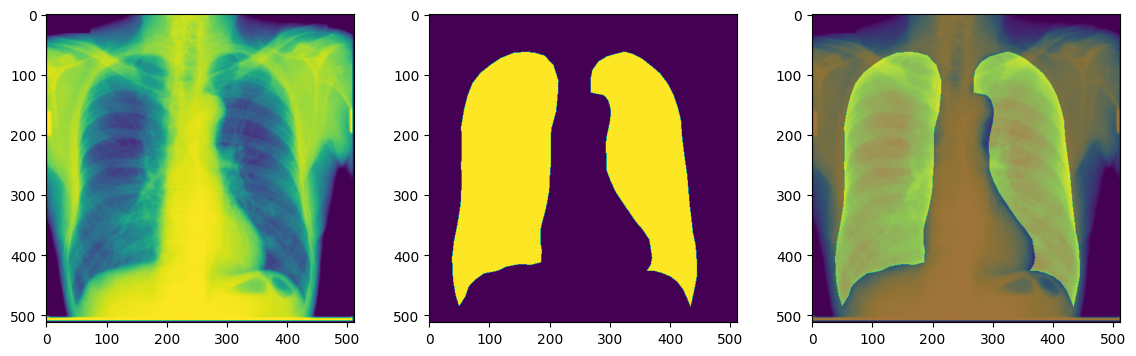

pixel range: 0 255
mask: {0: 169889, 1: 92255}


In [19]:
for i in range(0, 1):
    show_images_mask("JSRT", idx=i)

../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Montgomery/Images/MCUCXR_0055_0.png
../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Montgomery/Masks/MCUCXR_0055_0.png


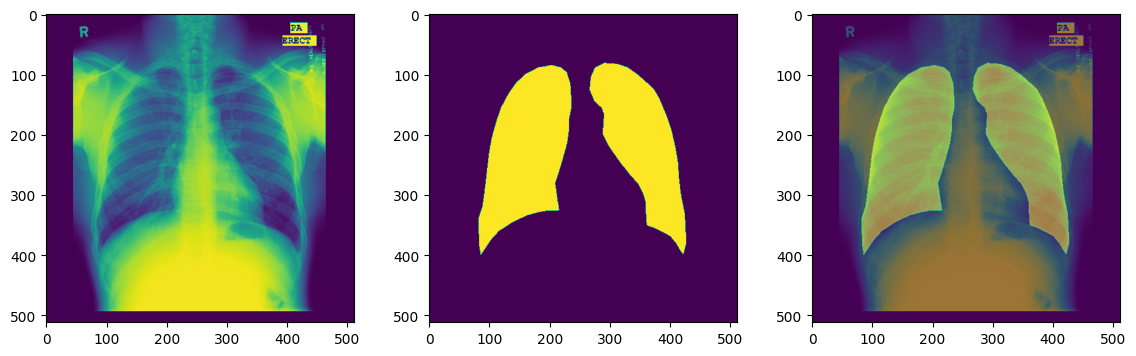

pixel range: 0 255
mask: {0: 207397, 1: 54747}


In [20]:
for i in range(0, 1):
    show_images_mask("Montgomery", idx=i)

../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Shenzhen/Images/CHNCXR_0590_1.png
../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Shenzhen/Masks/CHNCXR_0590_1.png


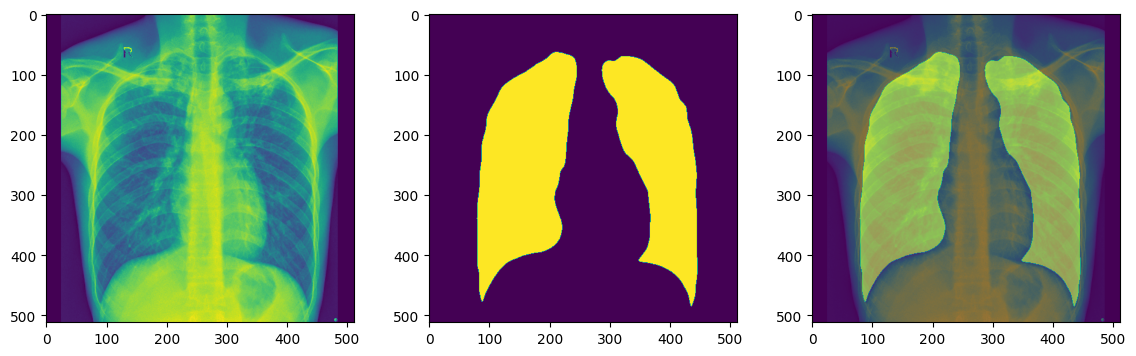

pixel range: 0 255
mask: {0: 183385, 1: 78759}


In [21]:
for i in range(0, 1):
    show_images_mask("Shenzhen", idx=i)

../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Indiana/Images/1060_IM-0042-1001.png
../../../purrlab_students/Segmentation-data/Segmentation_preprocessed/Indiana/Masks/1060_IM-0042-1001.png


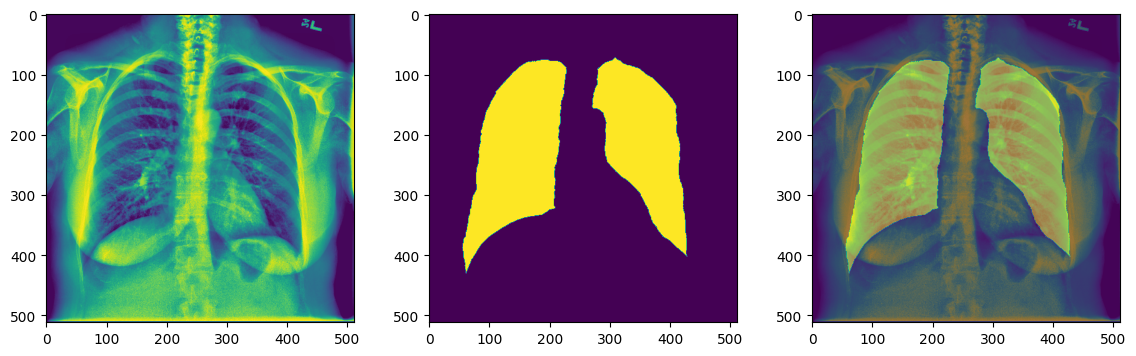

pixel range: 0 255
mask: {0: 199494, 1: 62650}


In [23]:
for i in range(0, 1):
    show_images_mask("Indiana", idx=i)
